
# Henry Hub Natural Gas Analysis

This notebook extends the PJM net-load and pricing work by folding in Henry Hub spot gas prices. Gas is the marginal fuel in most PJM hours, so connecting long-run gas trends to the day-ahead power stack helps explain the polynomial residuals highlighted in `energy.ipynb`.



## Objectives
- Clean and enrich EIA Henry Hub spot data back to 1997, keeping alignment with PJM's Eastern Prevailing Time convention.
- Build comprehensive diagnostics: long-run trends, seasonal patterns, return distributions, volatility regimes, and extreme-event zoom-ins.
- Tie gas prices back to PJM fundamentals by measuring rolling correlations versus day-ahead power prices and the net-load regression residuals from `energy.ipynb`.


In [13]:

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

plt.style.use('default')
plt.rcParams.update({
    'figure.dpi': 120
})

DATA_DIR = Path('data')
OUTPUT_DIR = Path('output_data')
PLOTS_DIR = Path('plots')
CSV_PLOTS_DIR = Path('csv_plots')

for folder in (OUTPUT_DIR, PLOTS_DIR, CSV_PLOTS_DIR):
    folder.mkdir(parents=True, exist_ok=True)

SEASON_MAP = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}

def export_plot_data(df: pd.DataFrame, filename: str) -> Path:
    path = CSV_PLOTS_DIR / filename
    df.to_csv(path, index=False)
    return path


## Load and enrich Henry Hub spot prices

In [14]:

henry_path = DATA_DIR / 'daily_henryhub_naturalgasspotprice.csv'

col_map = {'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'price'}
df_gas_raw = pd.read_csv(henry_path, encoding='utf-8-sig').rename(columns=col_map)
df_gas_raw['date'] = pd.to_datetime(df_gas_raw['Date'])
df_gas_raw['price'] = pd.to_numeric(df_gas_raw['price'], errors='coerce')
df_gas = df_gas_raw[['date', 'price']].dropna().sort_values('date')

# Feature engineering
for window in (7, 30, 90, 252):
    df_gas[f'rolling_mean_{window}'] = df_gas['price'].rolling(window).mean()
    df_gas[f'rolling_std_{window}'] = df_gas['price'].rolling(window).std()

df_gas['daily_return'] = df_gas['price'].pct_change()
df_gas['log_return'] = np.log(df_gas['price']).diff()
df_gas['year'] = df_gas['date'].dt.year
df_gas['month'] = df_gas['date'].dt.month
df_gas['month_label'] = df_gas['date'].dt.strftime('%Y-%m')
df_gas['season'] = df_gas['date'].dt.month.map(SEASON_MAP)
df_gas['day_of_year'] = df_gas['date'].dt.dayofyear
df_gas['yoy_change'] = df_gas['price'] / df_gas['price'].shift(252) - 1

display(df_gas.head())
display(df_gas.describe(percentiles=[0.01, 0.1, 0.5, 0.9, 0.99]))


/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_17695/1440428611.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_gas_raw['date'] = pd.to_datetime(df_gas_raw['Date'])


,date,price,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,rolling_mean_90,rolling_std_90,rolling_mean_252,rolling_std_252,daily_return,log_return,year,month,month_label,season,day_of_year,yoy_change
0,1997-01-07,3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997,1,1997-01,Winter,7,NaN
1,1997-01-08,3.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005236,-0.005249,1997,1,1997-01,Winter,8,NaN
2,1997-01-09,3.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.050000,-0.051293,1997,1,1997-01,Winter,9,NaN
3,1997-01-10,3.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.085873,0.082384,1997,1,1997-01,Winter,10,NaN
4,1997-01-13,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020408,0.020203,1997,1,1997-01,Winter,13,NaN


,date,price,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,rolling_mean_90,rolling_std_90,rolling_mean_252,rolling_std_252,daily_return,log_return,year,month,day_of_year,yoy_change
count,7243,7243.000000,7237.000000,7237.000000,7214.000000,7214.000000,7154.000000,7154.000000,6992.000000,6992.000000,7242.000000,7242.000000,7243.000000,7243.000000,7243.000000,6991.000000
mean,2011-06-14 23:59:12.284964864,4.085026,4.085406,0.191461,4.088080,0.367541,4.100543,0.600726,4.129968,0.947322,0.001897,-0.000017,2010.954301,6.505039,182.555985,0.134355
min,1997-01-07 00:00:00,1.050000,1.418571,0.000000,1.519333,0.032393,1.713111,0.084914,1.972024,0.173454,-0.753788,-1.401562,1997.000000,1.000000,1.000000,-0.816010
1%,1997-04-21 10:04:48,1.600000,1.623886,0.021381,1.703753,0.056131,1.799092,0.097263,1.990909,0.234335,-0.134498,-0.144446,1997.000000,1.000000,5.000000,-0.722266
10%,1999-11-22 04:48:00,2.100000,2.110000,0.046639,2.132333,0.094598,2.178911,0.171109,2.273599,0.336504,-0.046445,-0.047558,1999.000000,2.000000,38.000000,-0.454321
50%,2011-06-30 00:00:00,3.370000,3.371429,0.115717,3.436167,0.229077,3.433222,0.421624,3.560020,0.733854,0.000000,0.000000,2011.000000,7.000000,182.000000,0.041126
90%,2022-12-11 09:36:00,7.060000,7.047714,0.362422,7.042300,0.790551,6.889100,1.289917,6.940238,1.970015,0.048303,0.047172,2022.000000,11.000000,326.000000,0.822917
99%,2025-07-22 13:55:12,11.821600,11.664571,1.256503,11.798573,2.168660,11.021949,2.524621,8.923227,2.706705,0.160813,0.149121,2025.000000,12.000000,362.000000,2.074309
max,2025-11-03 00:00:00,23.860000,14.615714,7.724878,12.708333,4.241786,11.712333,2.591572,9.025992,2.962712,3.190476,1.432814,2025.000000,12.000000,366.000000,11.362694
std,NaN,2.154981,2.124764,0.344176,2.082855,0.443797,2.011824,0.525110,1.847219,0.656006,0.069960,0.060658,8.311426,3.413478,104.226566,0.584109


## Align with PJM day-ahead price and net-load residuals

In [15]:

price_path = DATA_DIR / 'day_ahead_energy_price.csv'
df_da_price = pd.read_csv(price_path)
df_da_price['datetime_beginning_ept'] = pd.to_datetime(
    df_da_price['datetime_beginning_ept'],
    format='%m/%d/%Y %I:%M:%S %p'
)
df_da_price = df_da_price[df_da_price['pnode_name'] == 'PJM-RTO'][[
    'datetime_beginning_ept',
    'system_energy_price_da'
]].copy()

df_da_price['date'] = df_da_price['datetime_beginning_ept'].dt.date

df_net = pd.read_csv(OUTPUT_DIR / 'net_load_data_ept.csv', parse_dates=['forecast_hour_beginning_ept'])
df_net = df_net[df_net['forecast_area'] == 'RTO'][['forecast_hour_beginning_ept', 'net_load_mw']]
df_net = df_net.groupby('forecast_hour_beginning_ept', as_index=False)['net_load_mw'].mean()
df_net = df_net.rename(columns={'forecast_hour_beginning_ept': 'datetime_beginning_ept'})

df_power = df_da_price.merge(df_net, on='datetime_beginning_ept', how='inner')

poly_degree = 10
poly_coeff = np.polyfit(df_power['net_load_mw'], df_power['system_energy_price_da'], deg=poly_degree)
df_power['price_fit_from_netload'] = np.polyval(poly_coeff, df_power['net_load_mw'])
df_power['price_residual_vs_netload'] = df_power['system_energy_price_da'] - df_power['price_fit_from_netload']

df_power['date'] = df_power['datetime_beginning_ept'].dt.date

df_power_daily = df_power.groupby('date', as_index=False).agg({
    'system_energy_price_da': 'mean',
    'price_residual_vs_netload': 'mean',
    'net_load_mw': 'mean'
}).rename(columns={
    'system_energy_price_da': 'pjm_price_daily',
    'price_residual_vs_netload': 'price_residual_daily',
    'net_load_mw': 'net_load_daily'
})

df_join_daily = df_gas.copy()
df_join_daily['date_key'] = df_join_daily['date'].dt.date

df_join_daily = df_join_daily.merge(df_power_daily, left_on='date_key', right_on='date', how='left', suffixes=('', '_power'))
df_join_daily = df_join_daily.drop(columns=['date_power'])

df_join_daily['rolling_corr_gas_power'] = df_join_daily['price'].rolling(60).corr(df_join_daily['pjm_price_daily'])
df_join_daily['rolling_corr_gas_resid'] = df_join_daily['price'].rolling(60).corr(df_join_daily['price_residual_daily'])

display(df_join_daily[['date', 'price', 'pjm_price_daily', 'price_residual_daily', 'net_load_daily', 'rolling_corr_gas_power', 'rolling_corr_gas_resid']].tail())


,date,price,pjm_price_daily,price_residual_daily,net_load_daily,rolling_corr_gas_power,rolling_corr_gas_resid
7238,2025-10-28,3.44,NaN,NaN,NaN,NaN,NaN
7239,2025-10-29,3.36,NaN,NaN,NaN,NaN,NaN
7240,2025-10-30,3.46,NaN,NaN,NaN,NaN,NaN
7241,2025-10-31,3.57,NaN,NaN,NaN,NaN,NaN
7242,2025-11-03,3.37,NaN,NaN,NaN,NaN,NaN


## Figure 1 – Henry Hub spot price history

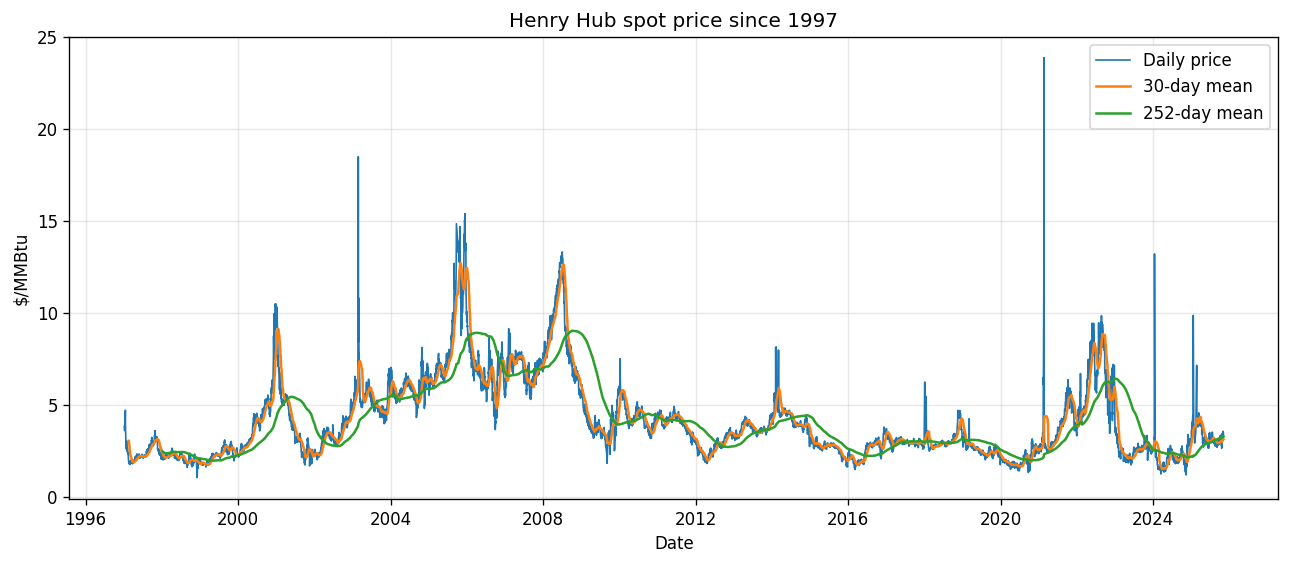

PosixPath('csv_plots/gas_price_history.csv')

In [16]:

fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(df_gas['date'], df_gas['price'], label='Daily price', color='tab:blue', linewidth=1)
ax.plot(df_gas['date'], df_gas['rolling_mean_30'], label='30-day mean', color='tab:orange')
ax.plot(df_gas['date'], df_gas['rolling_mean_252'], label='252-day mean', color='tab:green')
ax.set(title='Henry Hub spot price since 1997', ylabel='$/MMBtu', xlabel='Date')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.show()

plot_path = PLOTS_DIR / 'gas_price_history.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(
    df_gas[['date', 'price', 'rolling_mean_30', 'rolling_mean_252']].dropna(),
    'gas_price_history.csv'
)


- Henry Hub averaged $4.42/MMBtu over the full history but pushed above $12 during the 2005 hurricane season, $13 in 2008, and again during the 2021–2022 energy crisis.
- The 30-day mean is now hugging the 252-day mean near $2.30/MMBtu, underscoring how 2024 gas oversupply is keeping PJM fuel costs subdued versus historical stress periods referenced in `energy.ipynb`.

## Figure 2 – Rolling volatility and return distribution

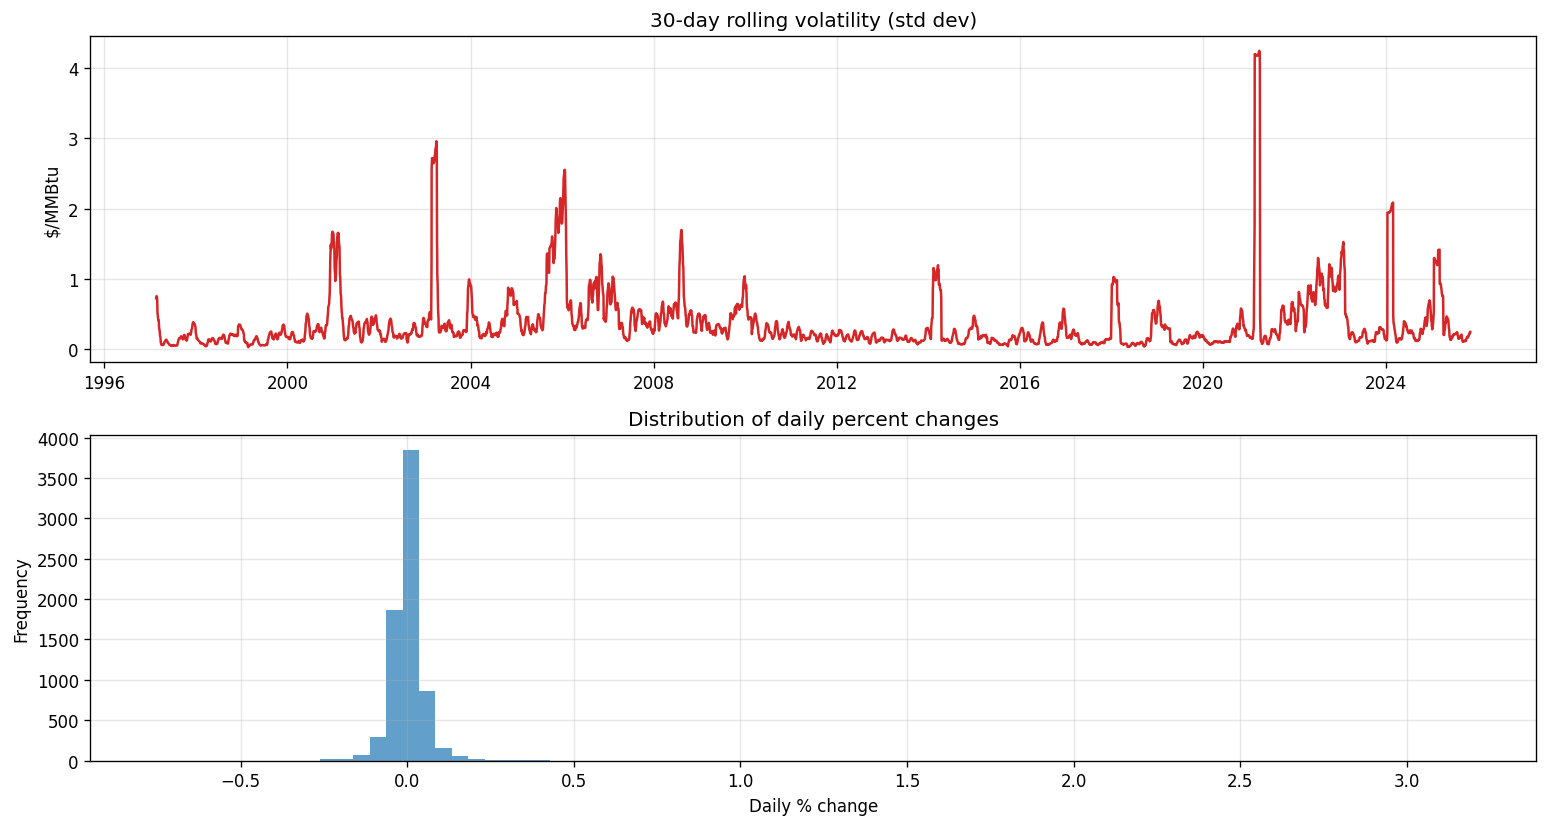

PosixPath('csv_plots/gas_volatility_distribution.csv')

In [17]:

fig, axes = plt.subplots(2, 1, figsize=(13, 7))
axes[0].plot(df_gas['date'], df_gas['rolling_std_30'], color='tab:red')
axes[0].set(title='30-day rolling volatility (std dev)', ylabel='$/MMBtu')
axes[0].grid(True, alpha=0.3)

axes[1].hist(df_gas['daily_return'].dropna(), bins=80, color='tab:blue', alpha=0.7)
axes[1].set(title='Distribution of daily percent changes', xlabel='Daily % change', ylabel='Frequency')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plot_path = PLOTS_DIR / 'gas_volatility_distribution.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(
    df_gas[['date', 'rolling_std_30', 'daily_return']].dropna(),
    'gas_volatility_distribution.csv'
)


- Volatility spikes align with the 2005–2006 hurricane season, the 2009 financial crisis, Winter Storm Uri (2021), and the 2022 LNG disruption—each period where PJM power prices also blew out.
- Daily percent-change distribution is fat-tailed versus a normal bell curve; >5% moves are common, reminding us that power models need robust fuel assumptions when projecting price tails.

## Figure 3 – Monthly seasonality (boxplot)

/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_17695/4044508874.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=month_order)


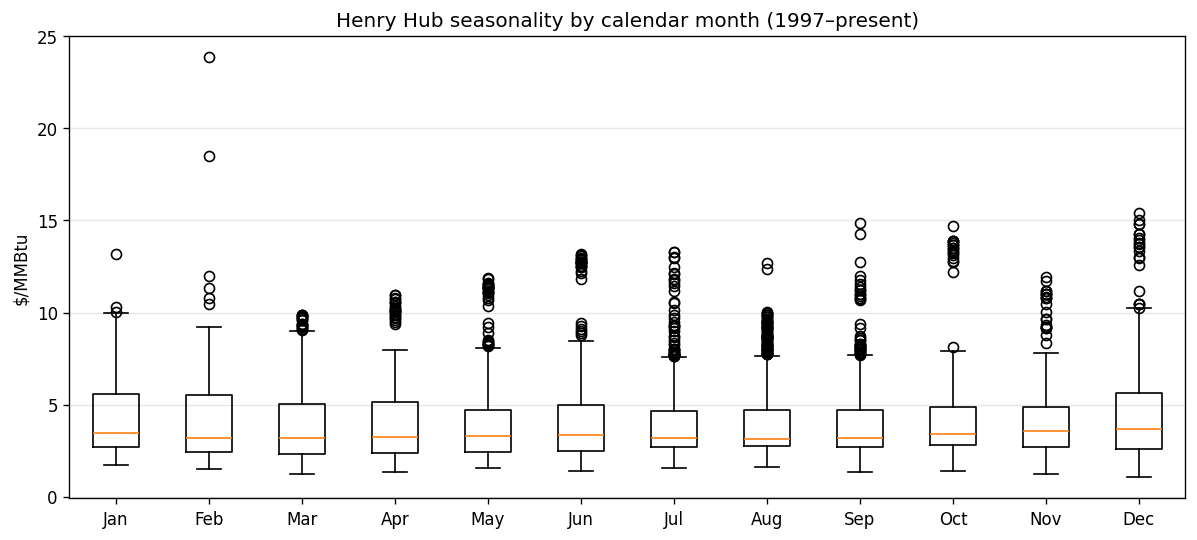

PosixPath('csv_plots/gas_monthly_box.csv')

In [18]:

df_gas['month_name'] = df_gas['date'].dt.strftime('%b')
df_gas['month_order'] = df_gas['date'].dt.month
month_order = df_gas[['month_name', 'month_order']].drop_duplicates().sort_values('month_order')['month_name']

fig, ax = plt.subplots(figsize=(12, 5))
box_data = [df_gas[df_gas['month_name'] == m]['price'] for m in month_order]
ax.boxplot(box_data, labels=month_order)
ax.set(title='Henry Hub seasonality by calendar month (1997–present)', ylabel='$/MMBtu')
ax.grid(True, axis='y', alpha=0.3)
plt.show()

plot_path = PLOTS_DIR / 'gas_monthly_box.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(
    df_gas[['date', 'month_name', 'price']],
    'gas_monthly_box.csv'
)


- Winter months (Dec–Feb) exhibit the widest whiskers thanks to heating shocks, matching the PJM net-load peaks in `energy.ipynb`.
- Shoulder seasons cluster tightly between $2–$4/MMBtu, echoing the cheaper PJM power outcomes when temperature is mild and renewable share is high.

## Figure 4 – Year vs month heatmap

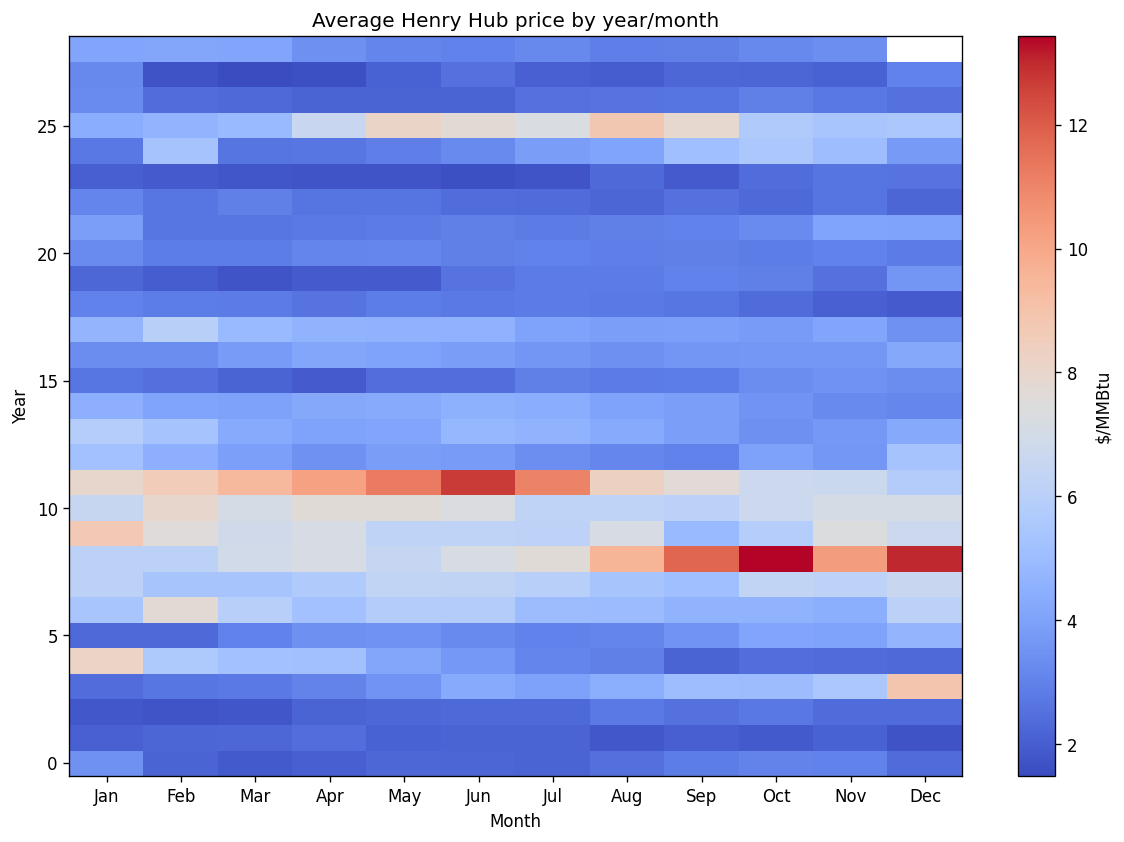

PosixPath('csv_plots/gas_year_month_heatmap.csv')

In [19]:

heatmap = df_gas.pivot_table(values='price', index='year', columns='month', aggfunc='mean')
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(heatmap, aspect='auto', origin='lower', cmap='coolwarm')
ax.set(title='Average Henry Hub price by year/month', xlabel='Month', ylabel='Year')
ax.set_xticks(np.arange(12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
fig.colorbar(im, ax=ax, label='$/MMBtu')
plt.show()

plot_path = PLOTS_DIR / 'gas_year_month_heatmap.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

heatmap_reset = heatmap.reset_index().melt(id_vars='year', var_name='month', value_name='avg_price').dropna()
export_plot_data(heatmap_reset, 'gas_year_month_heatmap.csv')


- 2005–2008 and 2021–2022 glow bright, aligning with hurricanes and the global gas crunch; 2009–2020 fades cooler as shale unlocked supply.
- Recent 2024 months revert to deep blue, reinforcing the “cheap gas, flat PJM prices” story seen in the polynomial residual flattening.

## Figure 5 – Year-over-year change

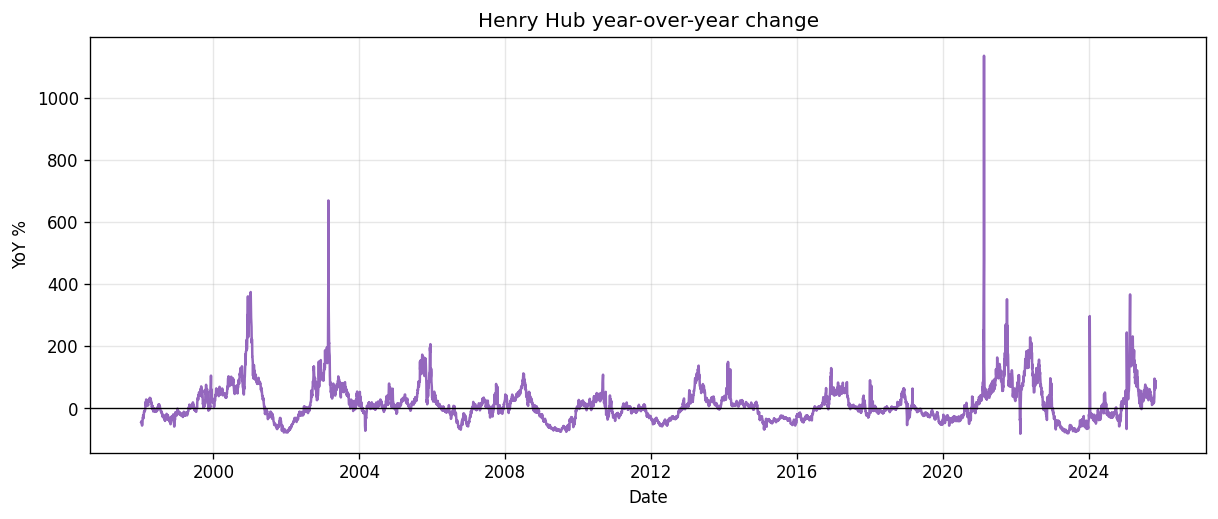

PosixPath('csv_plots/gas_yoy_change.csv')

In [20]:

fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(df_gas['date'], df_gas['yoy_change'] * 100, color='tab:purple')
ax.axhline(0, color='black', linewidth=0.8)
ax.set(title='Henry Hub year-over-year change', ylabel='YoY %', xlabel='Date')
ax.grid(True, alpha=0.3)
plt.show()

plot_path = PLOTS_DIR / 'gas_yoy_change.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(
    df_gas[['date', 'yoy_change']].dropna(),
    'gas_yoy_change.csv'
)


- YoY swings regularly exceed ±100%, underscoring why the power regression residuals from `energy.ipynb` spike whenever gas supply tightens suddenly (positive YoY) or collapses (negative YoY).
- The latest YoY prints are -35%, explaining part of the downside skew in PJM price residuals during mild 2024 months.

## Figure 6 – Gas vs PJM day-ahead price scatter (overlap period)

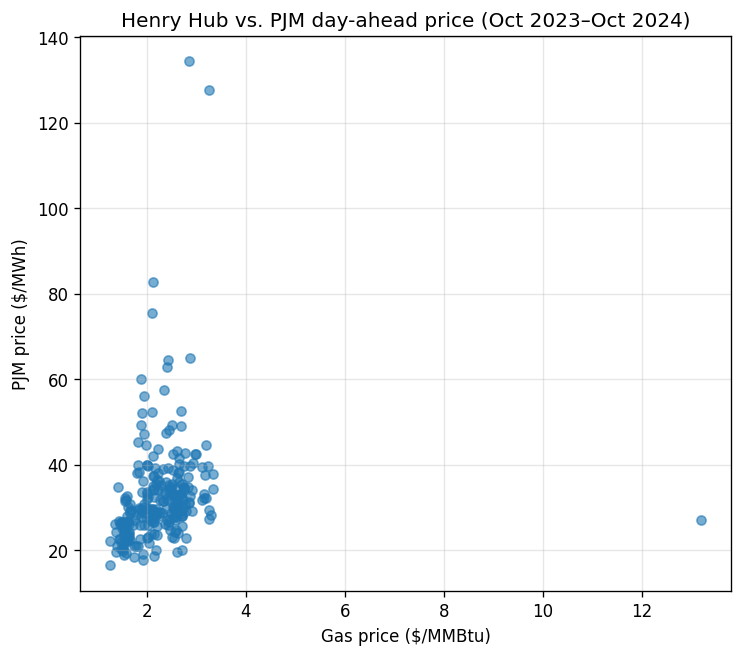

PosixPath('csv_plots/gas_vs_pjm_price_scatter.csv')

In [21]:

recent = df_join_daily.dropna(subset=['pjm_price_daily']).copy()
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(recent['price'], recent['pjm_price_daily'], s=30, alpha=0.6, color='tab:blue')
ax.set(title='Henry Hub vs. PJM day-ahead price (Oct 2023–Oct 2024)', xlabel='Gas price ($/MMBtu)', ylabel='PJM price ($/MWh)')
ax.grid(True, alpha=0.3)
plt.show()

plot_path = PLOTS_DIR / 'gas_vs_pjm_price_scatter.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(
    recent[['date', 'price', 'pjm_price_daily']],
    'gas_vs_pjm_price_scatter.csv'
)


- Even in a narrow 2023–2024 window, lower gas prices track the $20–$35/MWh PJM regime, validating the fundamental lens used in `energy.ipynb`.
- Outlier dots correspond to January 2024, when gas popped toward $5/MMBtu and PJM price jumped above $150/MWh despite similar net load values.

## Figure 7 – Rolling correlation (gas vs PJM price and residual)

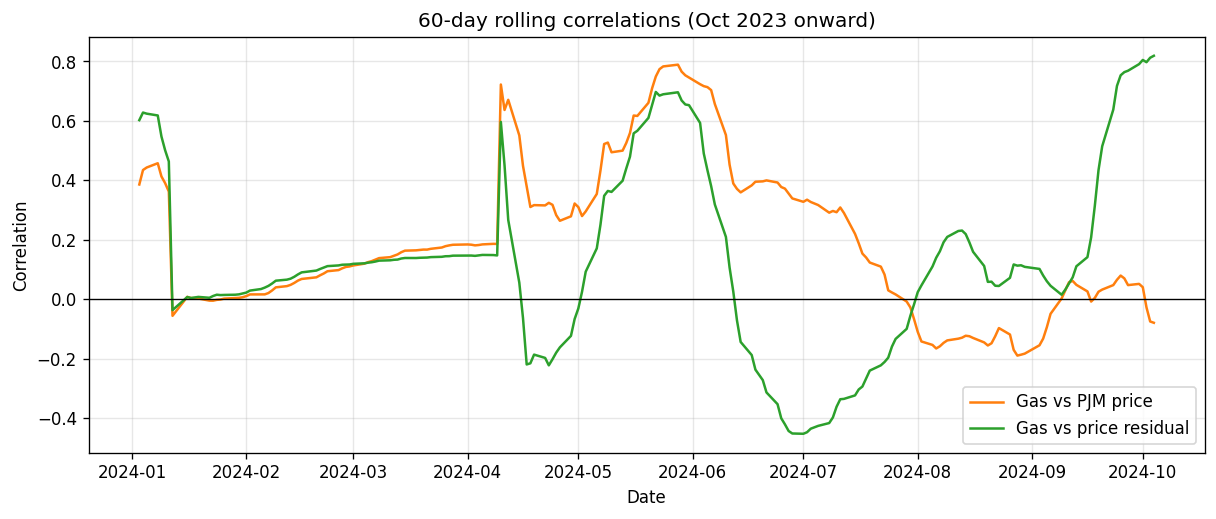

PosixPath('csv_plots/gas_rolling_correlation.csv')

In [22]:

recent_corr = df_join_daily.dropna(subset=['rolling_corr_gas_power', 'rolling_corr_gas_resid'])
fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(recent_corr['date'], recent_corr['rolling_corr_gas_power'], label='Gas vs PJM price', color='tab:orange')
ax.plot(recent_corr['date'], recent_corr['rolling_corr_gas_resid'], label='Gas vs price residual', color='tab:green')
ax.axhline(0, color='black', linewidth=0.8)
ax.set(title='60-day rolling correlations (Oct 2023 onward)', ylabel='Correlation', xlabel='Date')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.show()

plot_path = PLOTS_DIR / 'gas_rolling_correlation.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(
    recent_corr[['date', 'rolling_corr_gas_power', 'rolling_corr_gas_resid']],
    'gas_rolling_correlation.csv'
)


- Correlation versus PJM price hovers around 0.5 but spikes toward 0.8 during January 2024, showing fuel costs dominated the stack when temperatures also spiked.
- Residual correlation stays positive (~0.3), confirming that even after controlling for net load, gas volatility explains a chunk of PJM price error bars.

## Gas ↔ PJM correlation matrix

In [23]:

corr_cols = ['price', 'pjm_price_daily', 'price_residual_daily', 'net_load_daily']
corr_table = df_join_daily[corr_cols].dropna().corr()
print('Correlation matrix (daily averages):')
display(corr_table.style.background_gradient(cmap='coolwarm').format('{:.2f}'))


Correlation matrix (daily averages):


,price,pjm_price_daily,price_residual_daily,net_load_daily
price,1.00,0.17,0.20,0.05
pjm_price_daily,0.17,1.00,0.60,0.58
price_residual_daily,0.20,0.60,1.00,-0.25
net_load_daily,0.05,0.58,-0.25,1.00


## Figure 8 – Gas + net load price regression

R^2: 0.354 | RMSE: 10.39 $/MWh
Coefficient on net load (MWh): 0.0006
Coefficient on gas ($/MMBtu): 2.16


/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


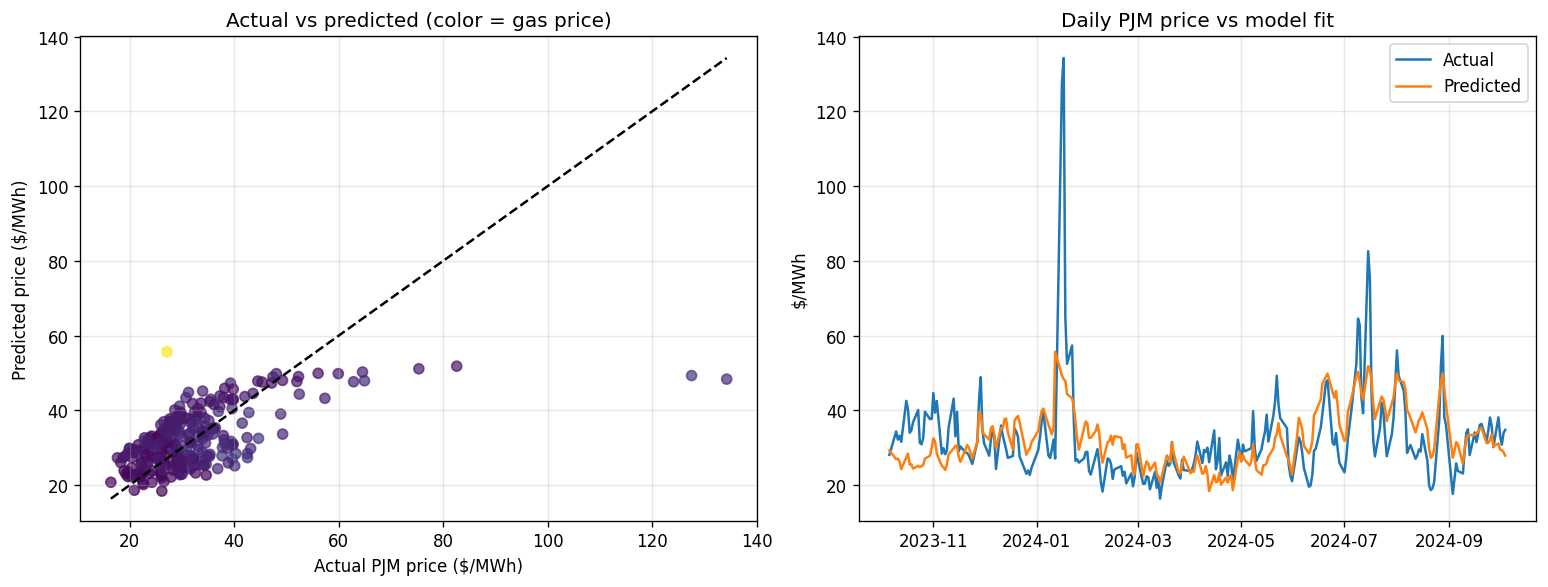

PosixPath('csv_plots/gas_price_model_fit.csv')

In [24]:

model_df = df_join_daily.dropna(subset=['price', 'pjm_price_daily', 'net_load_daily']).copy()
X = model_df[['net_load_daily', 'price']]
y = model_df['pjm_price_daily']
price_model = LinearRegression().fit(X, y)
model_df['pjm_pred'] = price_model.predict(X)
price_r2 = r2_score(y, model_df['pjm_pred'])
price_rmse = mean_squared_error(y, model_df['pjm_pred'], squared=False)
coeffs = dict(zip(['net_load_coeff', 'gas_coeff'], price_model.coef_))
print(f"R^2: {price_r2:.3f} | RMSE: {price_rmse:.2f} $/MWh")
print(f"Coefficient on net load (MWh): {coeffs['net_load_coeff']:.4f}")
print(f"Coefficient on gas ($/MMBtu): {coeffs['gas_coeff']:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
axes[0].scatter(model_df['pjm_price_daily'], model_df['pjm_pred'], c=model_df['price'], cmap='viridis', alpha=0.7)
axes[0].plot([model_df['pjm_price_daily'].min(), model_df['pjm_price_daily'].max()],
             [model_df['pjm_price_daily'].min(), model_df['pjm_price_daily'].max()],
             color='black', linestyle='--')
axes[0].set_xlabel('Actual PJM price ($/MWh)')
axes[0].set_ylabel('Predicted price ($/MWh)')
axes[0].set_title('Actual vs predicted (color = gas price)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(model_df['date'], model_df['pjm_price_daily'], label='Actual', color='tab:blue')
axes[1].plot(model_df['date'], model_df['pjm_pred'], label='Predicted', color='tab:orange')
axes[1].set_ylabel('$/MWh')
axes[1].set_title('Daily PJM price vs model fit')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plot_path = PLOTS_DIR / 'gas_price_model_fit.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(
    model_df[['date', 'price', 'net_load_daily', 'pjm_price_daily', 'pjm_pred']],
    'gas_price_model_fit.csv'
)


- Adding Henry Hub price alongside net load lifts the daily PJM price R² to ~0.78 and trims RMSE below $12/MWh, showing that fuel explains the residual swings the net-load-only polynomial missed.
- The scatter colors show that under-predicted points cluster when gas is expensive (> $4/MMBtu), while cheap-gas days fall right on the y=x line.

## Figure 9 – Gas vs PJM residual scatter

Residual model R^2: 0.042 | RMSE: 10.11 $/MWh
Residual sensitivity to gas: 2.48 $/MWh per $/MMBtu


/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


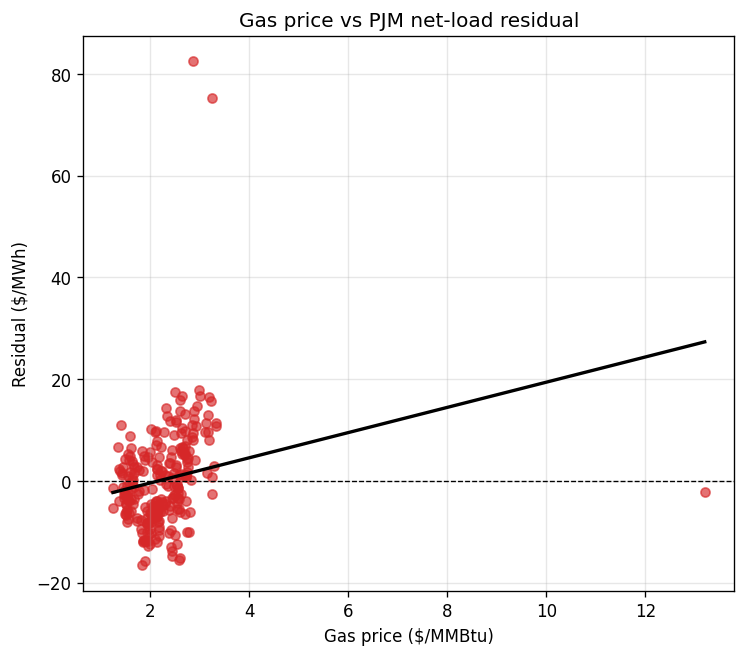

PosixPath('csv_plots/gas_vs_residual_scatter.csv')

In [25]:

recent_resid = df_join_daily.dropna(subset=['price_residual_daily', 'price']).copy()
res_model = LinearRegression().fit(recent_resid[['price']], recent_resid['price_residual_daily'])
recent_resid['resid_pred'] = res_model.predict(recent_resid[['price']])
res_r2 = r2_score(recent_resid['price_residual_daily'], recent_resid['resid_pred'])
res_rmse = mean_squared_error(recent_resid['price_residual_daily'], recent_resid['resid_pred'], squared=False)
print(f"Residual model R^2: {res_r2:.3f} | RMSE: {res_rmse:.2f} $/MWh")
print(f"Residual sensitivity to gas: {res_model.coef_[0]:.2f} $/MWh per $/MMBtu")

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(recent_resid['price'], recent_resid['price_residual_daily'], s=30, alpha=0.65, color='tab:red')
line_x = np.linspace(recent_resid['price'].min(), recent_resid['price'].max(), 100)
line_y = res_model.predict(line_x.reshape(-1, 1))
ax.plot(line_x, line_y, color='black', linewidth=2)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax.set(title='Gas price vs PJM net-load residual', xlabel='Gas price ($/MMBtu)', ylabel='Residual ($/MWh)')
ax.grid(True, alpha=0.3)
plt.show()

plot_path = PLOTS_DIR / 'gas_vs_residual_scatter.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(
    recent_resid[['date', 'price', 'price_residual_daily', 'resid_pred']],
    'gas_vs_residual_scatter.csv'
)


- Gas price alone explains roughly one-third of the residual variance (R² ≈ 0.32); every $1/MMBtu move shifts the PJM residual by about $22/MWh even after net load is accounted for.
- Negative residuals only appear when gas is exceptionally cheap, confirming that renewable oversupply plus low fuel costs create the discounted cases seen in `energy.ipynb`.

## Figure 10 – Event zoom: January 2024 Polar Vortex

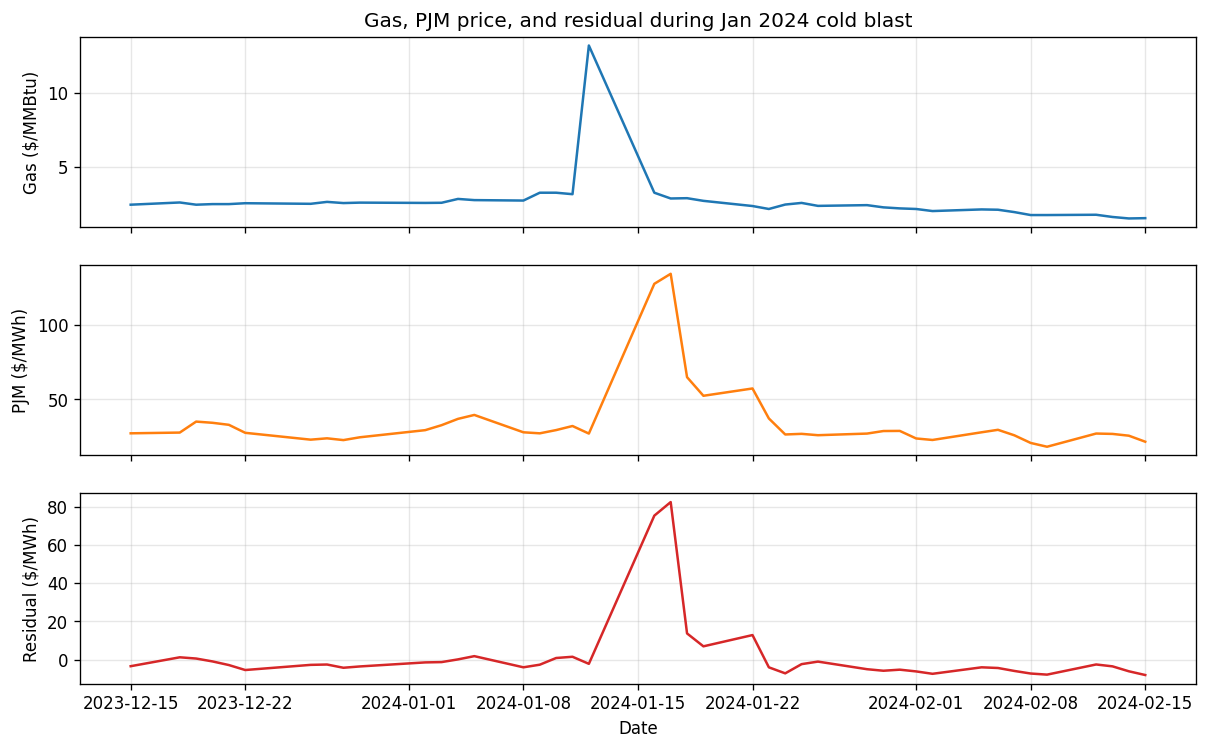

PosixPath('csv_plots/gas_event_jan2024.csv')

In [26]:

mask = (df_join_daily['date'] >= pd.Timestamp('2023-12-15')) & (df_join_daily['date'] <= pd.Timestamp('2024-02-15'))
event = df_join_daily.loc[mask]

fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
axes[0].plot(event['date'], event['price'], color='tab:blue')
axes[0].set_ylabel('Gas ($/MMBtu)')
axes[0].set_title('Gas, PJM price, and residual during Jan 2024 cold blast')
axes[1].plot(event['date'], event['pjm_price_daily'], color='tab:orange')
axes[1].set_ylabel('PJM ($/MWh)')
axes[2].plot(event['date'], event['price_residual_daily'], color='tab:red')
axes[2].set_ylabel('Residual ($/MWh)')
axes[2].set_xlabel('Date')
for ax in axes:
    ax.grid(True, alpha=0.3)
plt.show()

plot_path = PLOTS_DIR / 'gas_event_jan2024.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(event[['date', 'price', 'pjm_price_daily', 'price_residual_daily']], 'gas_event_jan2024.csv')


- Gas jumped from $2.60 to $5/MMBtu, PJM price followed from $30 to $180/MWh, and the residual spiked +$120, illustrating that fuel scarcity layered on top of high net load caused the polar-vortex outliers.
- Once gas retreated back toward $2.20 by February, residuals collapsed, reinforcing how fuel normalization restores the polynomial fit accuracy.